In [2]:
addprocs()
#rmprocs()

4-element Array{Int64,1}:
 2
 3
 4
 5

In [1]:
using Plots; gr()
#using Rsvg
#using DataFrames
#using CSV
@everywhere using Distributions
@everywhere using Rotations
# @everywhere using RandomNumbers.Xorshifts
# @everywhere rng = Xoroshiro128Plus()

In [2]:
function Q(X_Q::Array{Float64}, s_cz::Float64)
    return (1 ./ s_cz .* sqrt(2 / pi) .* (
        (3 .* X_Q.^2 ./ 2 ./ s_cz^2 .- 1) .* exp(-X_Q.^2 ./ 2 ./ s_cz^2) .-
        (4 .* X_Q.^2 ./ 3 ./ s_cz^2 .- 1) .* exp(-2 .* X_Q.^2 ./ 3 ./ s_cz^2)))
end

function R(eta::Array{Float64})
    return 3 .* eta .* (1 .- eta.^2 ./ 9) .* (1 .+ eta.^2 ./ 3).^(-5 / 2)
end

R (generic function with 1 method)

In [11]:
@everywhere const r = 10.0
@everywhere const addmatrix = [[r, 0.0, 0.0], [-r, 0.0, 0.0], [0.0, r, 0.0], [0.0, -r, 0.0], [0.0, 0.0, r], [0.0, 0.0, -r]]


@everywhere function calc_efg(el::Array{Float64})
    efg = zeros(Float64, 3, 3)
    for k in 1:size(el)[1]
        r = norm(el[k,:])
        for i in 1:3
            for j in 1:3
                efg[i, j] += -(3 * el[k,i] * el[k,j]) / r^5
                if i == j
                    efg[i, j] += 1 / r^3
                end
            end
        end
    end
    return efg
end


@everywhere function get_params(efg::Array{Float64})
    ev = eigvals(efg)
    sort_index = sortperm(abs.(ev))
    V_xx = ev[sort_index[1]]
    V_yy = ev[sort_index[2]]
    V_zz = ev[sort_index[3]]
    eta = (V_xx - V_yy) / V_zz
    dirz = eigvecs(efg)[:,sort_index[3]]
    dirx = eigvecs(efg)[:,sort_index[1]]
    return V_zz, eta, dirz, dirx
end


@everywhere function calc(fun; n::Int64=1000000, runs::Int64=1, sigma::Float64=0.01)
    Vzz = zeros(Float64, n)
    eta = zeros(Float64, n)
    dir = zeros(Float64, (n, 3))
    pos = zeros(Float64, (6, 3))
    pos = gen_okt!(pos)
    for i in 1:n
        # pos = move(pos, r, sigma)
        pos = fun(pos, runs=runs, sigma=sigma)
        efg = calc_efg(pos)
        Vzz[i], eta[i], dir[i,:] = get_params(efg)
        #Vzz[i], eta[i], dir[i,:] = get_params(calc_efg(fun(r, sigma)))
    end

    dis = zeros(Float64, n-1)
    for i in 2:n
        dis[i-1] = sqrt(sum((dir[i-1,:] - dir[i,:]) .^ 2))
    end
    
    return Vzz, eta, dis
end

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] exp(::Array{Float64,1}) at ./deprecated.jl:57
 [3] Q(::Array{Float64,1}, ::Float64) at ./In[2]:2
 [4] include_string(::String, ::String) at ./loading.jl:522
 [5] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /home/karajan/.julia/v0.6/IJulia/src/execute_request.jl:158
 [6] (::Compat.#inner#17{Array{Any,1},IJulia.#execute_request,Tuple{ZMQ.Socket,IJulia.Msg}})() at /home/karajan/.julia/v0.6/Compat/src/Compat.jl:385
 [7] eventloop(::ZMQ.Socket) at /home/karajan/.julia/v0.6/IJulia/src/eventloop.jl:8
 [8] (::IJulia.##14#17)() at ./task.jl:335
while loading In[23], in expression starting on line 4


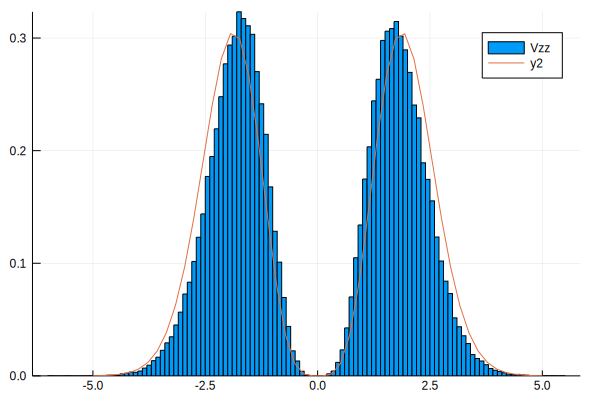

In [23]:
Vzz, eta, dis = calc(gen_okt!, n = 100000, sigma = 1.1e-5)
histogram(Vzz, normed=true,  label = "Vzz", bins = 200)
x = collect(linspace(-5.0, 5.0))
plot!(x, Q(x, 1.0))

In [5]:
function rotmat_()
    theta = rand() * 2π
    phi = rand() * 2π
    z = rand() * 2.0
    r = sqrt(z)
    Vx = sin(phi) * r
    Vy = cos(phi) * r
    Vz = sqrt(2.0 - z)
    st = sin(theta)
    ct = cos(theta)
    Sx = Vx * ct - Vy * st
    Sy = Vx * st + Vy * ct
    mat = Array{Float64}(3, 3)
    mat[0,0] = Vx * Sx - ct
    mat[1,0] = Vx * Sy - st
    mat[2,0] = Vx * Sx - ct
    mat[0,1] = Vy * Sx - ct
    mat[0,1] = Vy * Sx - ct
    mat[0,1] = Vy * Sx - ct
    mat[0,0] = Vx * Sx - ct
end


@everywhere function get_frequency(theta::Float64, phi::Float64, eta::Float64, deltaqq::Float64=1.0)
    costheta::Float64 = cos(theta)
    cos2phi::Float64 = cos(2*phi)
    A::Float64 = -3.375 + 2.25 * eta * cos2phi - 0.375 * (eta * cos2phi)^2
    B::Float64 = 3.75 - 0.5 * eta^2 - 2.0 * eta * cos2phi + 0.75 * (eta * cos2phi)^2
    C::Float64 = -0.375 + 1.0 / 3.0 * eta^2 - 0.25 * eta * cos2phi - 0.375 * (eta * cos2phi)^2
    return deltaqq * (A * costheta^4 + B * costheta^2 + C)
end


@everywhere function gen_lifetime(lifetime0::Float64)
    r = rand()
    while r < 1e-20
        r = rand()
    end
    return -log(r) * lifetime0
end


@everywhere function pulvermittel_slow(n::Int64 = 100, endlife::Float64 = 32768.0, lifetime0::Float64 = 16.0, sigma = 0.01)
    times = [0.0]
    freqs = [0.0]
    for i in 1:n
        times_x, freqs_x = simulate(endlife, lifetime0, sigma)
        times = vcat(times, times_x .+ times[length(times)])
        freqs = vcat(freqs, freqs_x)
    end
    return times, freqs
end


@everywhere function pulvermittel(n::Int64 = 100, endlife::Float64 = 32768.0, lifetime0::Float64 = 16.0, sigma = 0.01)
    times = [0.0]
    freqs = [0.0]
    jobs = [@spawn simulate(endlife, lifetime0, sigma) for i=1:n]
    for j in jobs
        times_x, freqs_x = fetch(j)
        times = vcat(times, times_x .+ times[length(times)])
        freqs = vcat(freqs, freqs_x)
        #push!(freqs, freqs_x)
    end
    return times, freqs
end


@everywhere function simulate(endlife::Float64, lifetime0::Float64 = 16.0, sigma = 0.01)
    time = 0.0
    pos = gen_okt!(zeros(Float64, (6, 3)))
    rotmat = rand(RotMatrix{3})

    times::Array{Float64} = []
    freqs::Array{Float64} = []
    temp_pos = pos
    temp_freq = 0.0
    temp_Vzz = 0.0
    temp_eta = 0.0
    temp_theta = 0.0
    temp_phi = 0.0
    temp_dir = []
    while time < endlife
        pos = gen_okt!(pos, sigma=sigma)
        efg = calc_efg(pos)
        # efg = rotmat * efg
        Vzz, eta, dirz, dirx = get_params(efg)
        dirz /= norm(dirz)
        dirz = rotmat * dirz
        dirx::Array{Float64} = rotmat * dirx
        p = dirx - dot(dirx, dirz) * dirz
        theta = acos(dirz[3])
        phi = acos(dot(dirz, p) / (norm(dirz) * norm(p)))
        freq = get_frequency(theta, phi, eta, Vzz^2)
    
        
            
        push!(times, time)
        push!(freqs, freq)
        
        time += gen_lifetime(lifetime0)
    end
    return times, freqs
end

In [15]:
@everywhere function gen_okt!(pos::Array{Float64,2}; runs::Int64=1, sigma::Float64=0.01)
    randn!(pos)
    pos *= sigma
    r = 0.1
    pos[1, 1] += r
    pos[2, 1] -= r
    pos[3, 2] += r
    pos[4, 2] -= r
    pos[5, 3] += r
    pos[6, 3] -= r
    return pos
end

@everywhere function move!(pos::Array{Float64,2}; runs::Int64=1, sigma::Float64=0.01)
    #if rand() < 0.01
        # return gen_okt!(pos, runs, sigma)
    #    row = rand(1:6)
    #    pos[row,:] = sigma * randn(3) + addmatrix[row]
    #end
    for _ in 1:runs
        row = rand(1:6)
        x = sigma/20 * randn(3)
        dist = sum((pos[row,:] + x).^2)
        while (dist < 0.5) || (dist > 1.5)
            row = rand(1:6)
            x = sigma/20 * randn(3)
            dist = sqrt(sum((pos[row,:] + x).^2))
        end
        pos[row,:] += sigma/20 * randn(3) #+ addmatrix[row]
    end
    return pos    
end

In [8]:
job1 = @spawn pulvermittel(100, 32768.0, 1.0, 0.01)
job2 = @spawn pulvermittel(100, 32768.0, 1.0, 0.001)
times_rh, freqs_rh = fetch(job1)
times_xh, freqs_xh = fetch(job2)

LoadError: [91mOn worker 2:
[91mMethodError: no method matching start(::RemoteException)[0m
Closest candidates are:
  start([91m::SimpleVector[39m) at essentials.jl:258
  start([91m::Base.MethodList[39m) at reflection.jl:560
  start([91m::ExponentialBackOff[39m) at error.jl:107
  ...[39m
pulvermittel at ./In[6]:60
#87 at ./distributed/macros.jl:20
#103 at ./distributed/process_messages.jl:264 [inlined]
run_work_thunk at ./distributed/process_messages.jl:56
run_work_thunk at ./distributed/process_messages.jl:65 [inlined]
#96 at ./event.jl:73[39m

In [14]:
histogram(freqs_xh, label = "okt p", bins = 500)

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0.000 
 
 
 0.025 
 
 
 0.050 
 
 
 0.075 
 
 
 0 
 
 
 20000 
 
 
 40000 
 
 
 60000 
 
 
 80000 
 
<polyline clip-path="url(#clip4402)" style="stroke:#000000; stroke-width:1; stroke-opacity:1; fill:none" points="
 49.201,375.869 49.201,375.146 51.5002,375.146 51.5002,373.522 53.7993,373.522 53.7993,372.051 56.0985,372.051 56.0985,373.072 58.3977,373.072 58.3977,373.444 
 60.6969,373.444 60.6969,374.527 62.9961,374.527 62.9961,371.328 65.2953,371.328 65.2953,372.938 67.5945,372.938 67.5945,373.717 69.8937,373.717 69.8937,371.375 
 72.1929,371.375 72.1929,370.713 74.4921,370.713 74.4921,370.908 76.7913,370.908 76.7913,369.224 79.0905,369.224 79.0905,368.263 81.3897,368.263 81.3897,368.059 
 83.6889,368.059 83.6889,363.873 85.9881,363.873 85.9881,365.453 88.2873,365.453 88.2873,357.306 90.5865,357.306 90.5865,359.986 92.8857,359.986 92.8857,354.782 
 95.1849,354.782 95.1849,358.133 97.484,358.133 97.484,357.6 99.7832,357.6 99.7832,361.765 102.082,361.765 102.082,369.384 104.382,369.384 104.382,371.722 
 106.681,371.722 106.681,366.704 108.98,366.704 108.98,357.644 111.279,357.644 111.279,328.895 113.578,328.895 113.578,316.596 115.878,316.596 115.878,317.397 
 118.177,317.397 118.177,317.674 120.476,317.674 120.476,297.272 122.775,297.272 122.775,316.609 125.074,316.609 125.074,310.263 127.374,310.263 127.374,291.475 
 129.673,291.475 129.673,283.943 131.972,283.943 131.972,258.995 134.271,258.995 134.271,255.229 136.57,255.229 136.57,210.892 138.87,210.892 138.87,227.35 
 141.169,227.35 141.169,197.909 143.468,197.909 143.468,148.953 145.767,148.953 145.767,80.2607 148.066,80.2607 148.066,11.811 150.366,11.811 150.366,91.7541 
 152.665,91.7541 152.665,62.1483 154.964,62.1483 154.964,157.844 157.263,157.844 157.263,200.203 159.562,200.203 159.562,233.597 161.862,233.597 161.862,262.545 
 164.161,262.545 164.161,250.887 166.46,250.887 166.46,251.961 168.759,251.961 168.759,233.61 171.058,233.61 171.058,236.459 173.357,236.459 173.357,231.692 
 175.657,231.692 175.657,224.372 177.956,224.372 177.956,206.121 180.255,206.121 180.255,182.507 182.554,182.507 182.554,179.359 184.853,179.359 184.853,175.152 
 187.153,175.152 187.153,183.009 189.452,183.009 189.452,205.939 191.751,205.939 191.751,185.087 194.05,185.087 194.05,196.472 196.349,196.472 196.349,203.874 
 198.649,203.874 198.649,194.203 200.948,194.203 200.948,165.741 203.247,165.741 203.247,189.147 205.546,189.147 205.546,184.468 207.845,184.468 207.845,193.134 
 210.145,193.134 210.145,204.515 212.444,204.515 212.444,205.684 214.743,205.684 214.743,210.671 217.042,210.671 217.042,209.935 219.341,209.935 219.341,203.403 
 221.641,203.403 221.641,211.645 223.94,211.645 223.94,211.411 226.239,211.411 226.239,207.68 228.538,207.68 228.538,214.372 230.837,214.372 230.837,224.597 
 233.137,224.597 233.137,227.848 235.436,227.848 235.436,237.459 237.735,237.459 237.735,243.645 240.034,243.645 240.034,253.761 242.333,253.761 242.333,264.857 
 244.633,264.857 244.633,276.848 246.932,276.848 246.932,282.636 249.231,282.636 249.231,295.566 251.53,295.566 251.53,294.138 253.829,294.138 253.829,293.61 
 256.128,293.61 256.128,292.519 258.428,292.519 258.428,275.367 260.727,275.367 260.727,257.649 263.026,257.649 263.026,253.718 265.325,253.718 265.325,263.277 
 267.624,263.277 267.624,278.363 269.924,278.363 269.924,278.887 272.223,278.887 272.223,298.246 274.522,298.246 274.522,299.155 276.821,299.155 276.821,303.311 
 279.12,303.311 279.12,311.302 281.42,311.302 281.42,311.246 283.719,311.246 283.719,312.865 286.018,312.865 286.018,309.657 288.317,309.657 288.317,316.276 
 290.616,316.276 290.616,311.787 292.916,311.787 292.916,330.042 295.215,330.042 295.215,334.969 297.514,334.969 297.514,336.653 299.813,336.653 299.813,332.601 
 302.112,332.601 302.112,326.345 304.412,326.345 304.412,328.778 306.711,328.778 306.711,330.415 309.01,330.415 309.01,331.168 311.309,331.

In [9]:
@time times_ph, freqs_ph = pulvermittel(100, 16384.0, 1.0, 0.001)
times_p, freqs_p = simulate(16384.0, 1.0, 0.01)
size(freqs_ph)

 53.813505 seconds (235.67 M allocations: 18.424 GiB, 3.87% gc time)


(1638442,)

In [13]:
times_ph2, freqs_ph2 = pulvermittel(100, 16384.0, 1.0, 0.001)

([0.0, 0.0, 0.505052, 2.23096, 5.28123, 6.93975, 7.88768, 8.02843, 10.7468, 11.1274  …  1.63829e6, 1.63829e6, 1.6383e6, 1.6383e6, 1.6383e6, 1.6383e6, 1.6383e6, 1.6383e6, 1.6383e6, 1.6383e6], [0.0, -0.000108909, -6.65347e-5, -2.35593e-5, -4.27424e-5, 7.68626e-5, -0.000155448, 0.000138306, 0.00033081, 2.08481e-5  …  0.000596581, 6.52093e-5, 7.44262e-5, 0.000227295, 0.000406211, 4.50874e-5, 2.29304e-5, 0.000201968, 0.0012562, -3.43182e-5])

In [18]:
times_ph3, freqs_ph3 = pulvermittel(100, 16384.0, 1.0, 0.1)

([0.0, 0.0, 0.237982, 0.360281, 1.15557, 1.60419, 2.91839, 3.27215, 4.73373, 4.86383  …  1.63829e6, 1.63829e6, 1.6383e6, 1.6383e6, 1.6383e6, 1.6383e6, 1.6383e6, 1.6383e6, 1.6383e6, 1.63831e6], [0.0, 0.035293, 4.23658, -0.533143, 0.161302, 1.3263, 0.0993916, 12.3455, 0.185539, -0.432498  …  4.07744, 3.48823, 1.06975, 0.467203, 0.327394, 0.266434, 0.310693, 25.6762, -0.604501, 0.0381856])

In [26]:
histogram(freqs_ph*-1, normed = true, label = "okt p001", bins = 500)
histogram!(freqs_ph3*-0.01, normed = true, label = "okt p1", bins = 500)
plot!(xlims = (-0.3, ))

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 -0.2 
 
 
 -0.1 
 
 
 0.0 
 
 
 0.1 
 
 
 0.2 
 
 
 0 
 
 
 10 
 
 
 20 
 
 
 30 
 
<polyline clip-path="url(#clip4802)" style="stroke:#000000; stroke-width:1; stroke-opacity:1; fill:none" points="
 139.366,375.869 139.366,375.862 140.285,375.862 140.285,375.869 141.204,375.869 142.122,375.869 143.041,375.869 
 143.96,375.869 144.878,375.869 145.797,375.869 145.797,375.862 146.715,375.862 146.715,375.869 147.634,375.869 
 148.553,375.869 149.471,375.869 150.39,375.869 151.309,375.869 152.227,375.869 
 153.146,375.869 154.065,375.869 154.983,375.869 155.902,375.869 155.902,375.862 156.821,375.862 156.821,375.869 
 157.739,375.869 158.658,375.869 159.576,375.869 160.495,375.869 161.414,375.869 
 162.332,375.869 163.251,375.869 164.17,375.869 164.17,375.862 165.088,375.862 165.088,375.869 166.007,375.869 
 166.926,375.869 167.844,375.869 168.763,375.869 169.682,375.869 170.6,375.869 
 171.519,375.869 172.437,375.869 173.356,375.869 174.275,375.869 175.193,375.869 
 176.112,375.869 177.031,375.869 177.949,375.869 178.868,375.869 178.868,375.862 179.787,375.862 179.787,375.869 
 180.705,375.869 180.705,375.862 181.624,375.862 182.543,375.862 183.461,375.862 184.38,375.862 
 185.298,375.862 186.217,375.862 186.217,375.855 187.136,375.855 187.136,375.869 188.054,375.869 188.054,375.855 188.973,375.855 188.973,375.862 
 189.892,375.862 190.81,375.862 191.729,375.862 191.729,375.869 192.648,375.869 192.648,375.862 193.566,375.862 193.566,375.855 
 194.485,375.855 195.404,375.855 195.404,375.862 196.322,375.862 197.241,375.862 197.241,375.869 198.16,375.869 198.16,375.862 
 199.078,375.862 199.078,375.869 199.997,375.869 199.997,375.862 200.915,375.862 200.915,375.849 201.834,375.849 201.834,375.869 202.753,375.869 202.753,375.855 
 203.671,375.855 204.59,375.855 204.59,375.862 205.509,375.862 206.427,375.862 206.427,375.849 207.346,375.849 207.346,375.842 
 208.265,375.842 208.265,375.862 209.183,375.862 209.183,375.855 210.102,375.855 210.102,375.869 211.021,375.869 211.021,375.849 211.939,375.849 
 212.858,375.849 212.858,375.862 213.776,375.862 213.776,375.849 214.695,375.849 214.695,375.855 215.614,375.855 215.614,375.869 216.532,375.869 216.532,375.862 
 217.451,375.862 218.37,375.862 219.288,375.862 219.288,375.842 220.207,375.842 220.207,375.836 221.126,375.836 221.126,375.829 
 222.044,375.829 222.044,375.849 222.963,375.849 222.963,375.869 223.882,375.869 223.882,375.842 224.8,375.842 224.8,375.849 225.719,375.849 225.719,375.836 
 226.637,375.836 226.637,375.842 227.556,375.842 227.556,375.862 228.475,375.862 228.475,375.842 229.393,375.842 230.312,375.842 230.312,375.796 
 231.231,375.796 231.231,375.842 232.149,375.842 232.149,375.822 233.068,375.822 233.068,375.803 233.987,375.803 233.987,375.836 234.905,375.836 234.905,375.842 
 235.824,375.842 235.824,375.803 236.743,375.803 236.743,375.829 237.661,375.829 238.58,375.829 238.58,375.809 239.498,375.809 239.498,375.816 
 240.417,375.816 241.336,375.816 242.254,375.816 242.254,375.789 243.173,375.789 243.173,375.796 244.092,375.796 244.092,375.803 
 245.01,375.803 245.01,375.756 245.929,375.756 245.929,375.803 246.848,375.803 246.848,375.737 247.766,375.737 247.766,375.796 248.685,375.796 248.685,375.75 
 249.604,375.75 249.604,375.756 250.522,375.756 250.522,375.71 251.441,375.71 251.441,375.743 252.359,375.743 252.359,375.737 253.278,375.737 253.278,375.783 
 254.197,375.783 254.197,375.75 255.115,375.75 256.034,375.75 256.034,375.743 256.953,375.743 256.953,375.73 257.871,375.73 257.871,375.651 
 258.79,375.651 258.79,375.697 259.709,375.697 259.709,375.637 260.627,375.637 260.627,375.704 261.546,375.704 261.546,375.664 262.465,375.664 262.465,375.618 
 263.383,375.618 263.383,375.585 264.302,375.585 264.302,375.598 265.22,375.598 265.22,375.624 266.139,375.624 266.139,375.558 267.058,375.558 267.058,375.604 
 267.976,375.604 267.976,375.492 268.895,375.4

In [ ]:
freqs_ph *= 100
freqs_p *= 100;

In [ ]:
job1 = @spawn simulate(32768.0, 1.0, 0.01)
job2 = @spawn simulate(32768.0, 1.0, 0.001)
times_r, freqs_r = fetch(job1)
times_x, freqs_x = fetch(job2)

In [ ]:
#plot(times, freqs, label = "okt")
#plot(times_r, freqs_r, label = "okt r")
plot(times_p, freqs_p, label = "okt p")
#plot!(freq_iso, label = "iso")
plot!(xlims = (0, 3600))
plot!(ylims = (-0.1, 0.1))

In [ ]:
savefig("traj vgl iso.pdf")

In [ ]:
n = length(freqs_p)
diff_p = Array{Float64}(n-1)
for i in 2:n
    diff_p[i-1] = abs(freqs_p[i] - freqs_p[i-1])
end
histogram(diff_p, label = "okt p", bins = 2500)
plot!(xlims = (0, 2))

In [ ]:
basedir = "/home/jens/Documents/simulation/NMRSimulation/test/okttest/"
freq_iso = CSV.read("$(basedir)freq_iso.txt", types=[Float64],  delim = " ")
freq_iso = convert(Array{Float64}, freq_iso)

In [ ]:
#histogram(freqs_rh, label = "okt sigma0.01", bins = 500)
# freqs_ph *= 0.8
# histogram(freq_iso, normed=true, label = "iso", bins = 70)
histogram(freqs_ph, normed=true,  label = "okt diff", bins = 200)
#plot(xlims = (-0.5, 0.5))

In [ ]:
savefig("spektrum vgl iso.pdf")